In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digital-turbine-auction-bid-price-prediction/sample_submission.csv
/kaggle/input/digital-turbine-auction-bid-price-prediction/train_data.csv
/kaggle/input/digital-turbine-auction-bid-price-prediction/test_data.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/digital-turbine-auction-bid-price-prediction/train_data.csv')
test_df = pd.read_csv('/kaggle/input/digital-turbine-auction-bid-price-prediction/test_data.csv')

# imports

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

In [4]:
# dataframe info stats

def stats(data):
    
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
        # 'nunique/len': data.nunique()/len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
        # 'Nullpercent' : data.isna().sum()/len(data),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len','types','Nulls'#,'Nullpercent', 'nunique/len'
                   ,"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)



def countPlot(col,num = 6,hue = None):
    sns.set(rc={'figure.figsize':(6,6)})
    ax = sns.countplot(x=col, data=train_df, hue = hue,
                   order=train_df[col].value_counts().iloc[:num].index)
    
    return plt.show()

In [5]:
train_df.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice,winBid,has_won
0,1656411567773,banner,LG,com.tilegarden.match3,1.8.22,LM-V405,US,74f9b473fad,Android-10.0,3G,cb2,6.0,6b,4.0,320x50,11.2.1,0.01,0.02,0.88,0
1,1656925395488,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,FR,6ad4c88b84e,Android-4.0,WIFI,7d3,6.0,6b,6.0,320x50,11.4.2,0.01,0.03,0.08,0
2,1656913751642,banner,Generic,com.loop.match3d,1245.35.0,Android 4.0,US,743b9849642,Android-4.0,WIFI,7d3,3.0,6b,3.0,320x50,11.4.3,0.01,0.02,1.72,0
3,1656656319103,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,GB,6ad933115b2,Android-4.0,WIFI,7d3,3.0,6b,5.0,320x50,11.4.2,0.01,0.06,0.21,0
4,1657429389462,interstitial,OPPO,com.loop.match3d,1245.35.0,CPH2127,ID,809f9785bb3,Android-11.0,WIFI,8bd,3.0,6b,3.0,320x480,11.4.3,0.01,0.16,1.91,0


In [6]:
test_df.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice
0,1657758857892,rewarded,Generic,com.loop.match3d,1245.35.0,Android 4 Tablet,US,6a0a94554cf,Android-4.0,3G,7b8,2.0,6b,2.0,768x1024,11.4.3,0.05,0.06
1,1657210707978,interstitial,Generic,com.loop.match3d,1245.35.0,Android 4.0,ZA,6a0b0e59f45,Android-4.0,WIFI,8bd,8.0,6b,6.0,320x480,11.4.3,0.01,0.16
2,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,13.0.02,Moto g(8) power lite,BR,6a0fa820c46,Android-10.0,WIFI,ea0,8.0,6b,9.0,320x480,11.0.0,0.05,0.06
3,1657386816882,interstitial,Huawei,com.tintash.nailsalon,1.3.6,JDN2-AL00HN,IQ,6a142bdbea2,Android-9.0,WIFI,3dc,6.0,6b,4.0,768x1024,11.3.3,0.01,0.05
4,1657211600823,banner,Generic,com.tilegarden.match3,1.8.52,Android 4.0,US,6a16943a771,Android-4.0,WIFI,cb2,7.0,6b,5.0,320x50,11.4.3,0.01,0.03


In [7]:
stats(train_df)

,nunique,len,types,Nulls,Value counts Max,Value counts Min
eventTimestamp,7302171,7321633,int64,0,4,1
deviceId,40176,7321633,object,0,25150,1
winBid,23008,7321633,float64,0,371679,1
sentPrice,7521,7321633,float64,0,1527464,1
correctModelName,2568,7321633,object,0,1973042,1
countryCode,168,7321633,object,27,2822649,1
brandName,144,7321633,object,0,2088820,1
appVersion,101,7321633,object,0,2911851,2
osAndVersion,96,7321633,object,0,2034520,2
c1,50,7321633,object,0,3758421,155


In [8]:
stats(test_df)

,nunique,len,types,Nulls,Value counts Max,Value counts Min
deviceId,41586,41586,object,0,1,1
eventTimestamp,41584,41586,int64,0,2,1
correctModelName,2614,41586,object,0,7720,1
sentPrice,1789,41586,float64,0,7035,1
countryCode,170,41586,object,6,10411,1
brandName,149,41586,object,0,9374,1
appVersion,101,41586,object,0,8686,1
osAndVersion,97,41586,object,0,12440,1
c1,50,41586,object,0,5626,12
mediationProviderVersion,35,41586,object,0,19158,1


# Eda

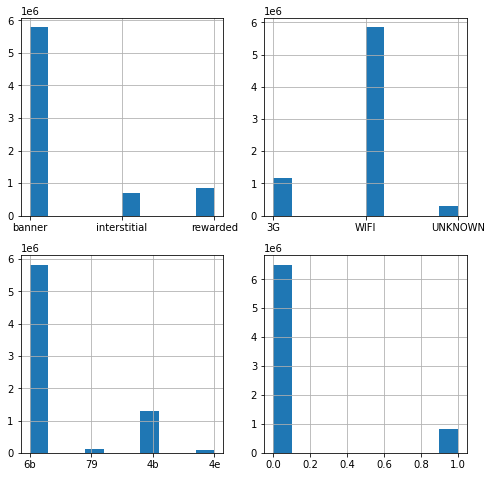

In [9]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()
train_df['unitDisplayType'].hist(figsize = (8, 8),ax=axes[0])
train_df['connectionType'].hist(figsize = (8, 8),ax=axes[1])
train_df['c3'].hist(figsize = (8, 8),ax=axes[2])
train_df['has_won'].hist(figsize = (8, 8),ax=axes[3])


plt.show()

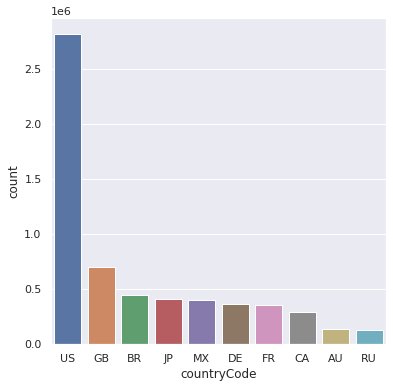

In [10]:
countPlot('countryCode',10)

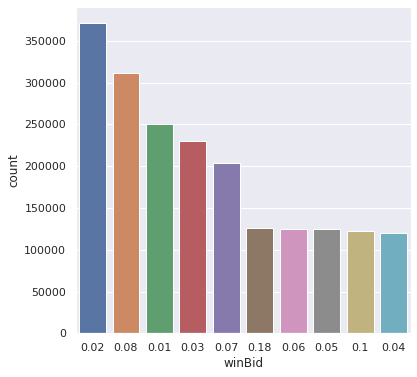

In [11]:
countPlot('winBid',10)

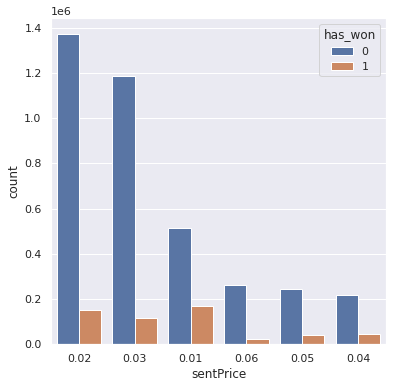

In [12]:
countPlot('sentPrice',6,'has_won')

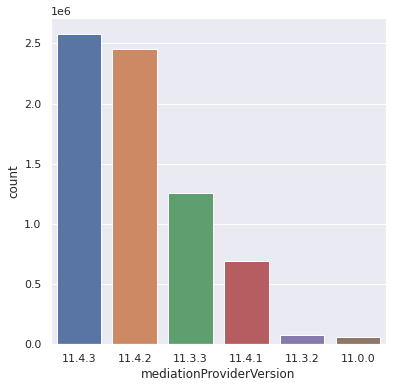

In [13]:
countPlot('mediationProviderVersion')

In [14]:
def percentile80(x):
    return np.percentile(x,80)

pivoted = train_df.pivot_table(index = ['countryCode'], values = ['winBid'], 
               aggfunc = [np.mean, np.median, np.std,'count', percentile80])

pivoted.columns = pivoted.columns.get_level_values(0)


pivoted.sort_values('count',ascending=False).head(17)

,mean,median,std,count,percentile80
countryCode,,,,,
US,7.029587,1.11,28.964468,2822649,3.45
GB,3.140568,0.18,14.015662,706591,1.11
BR,0.718415,0.12,2.233045,449634,0.58
JP,2.288190,0.12,10.761786,411060,0.87
MX,0.656103,0.08,2.025010,400655,0.76
DE,3.063240,0.13,14.806951,361675,1.10
FR,1.829582,0.08,9.504099,356938,0.94
CA,4.555101,0.51,23.964473,295789,2.10
AU,6.790936,0.50,26.668236,140159,4.62


# preprocessing

In [15]:
# Q&D
# try with missing
train_df.fillna({'countryCode':'US', 'connectionType':'UNKNOWN'}, inplace=True)
test_df.fillna({'countryCode':'US', 'connectionType':'UNKNOWN'}, inplace=True)
                                    

In [16]:
## TODO  fill na in country code by other columns

# columns = ['brandName','correctModelName','connectionType','countryCode']

# fill_null_df = train_df[columns + ['winBid']]\
# .groupby(columns, as_index=False,sort=True).count()

# fillcountrycode = fill_null_df.sort_values(by=['brandName','correctModelName','connectionType','winBid'],ascending=False).drop_duplicates(['brandName','correctModelName','connectionType'])
# fillconnectiontype = fill_null_df.sort_values(by=['brandName','correctModelName','countryCode','winBid'],ascending=False).drop_duplicates(['brandName','correctModelName','countryCode'])


In [17]:
cols = ['c2', 'c4']
train_df[cols] = train_df[cols].applymap(np.int16)
test_df[cols] = test_df[cols].applymap(np.int16)

# select columns

In [18]:
train_columns = [ 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode',# 'deviceId',
       'osAndVersion', 'connectionType', 'c1', 'c2', 'c3', 'c4', 'size',
       'mediationProviderVersion', 'bidFloorPrice'#,'has_won'
       ]

cat_columns = [ 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode', #'deviceId',
       'osAndVersion', 'connectionType', 'c1', 'c2', 'c3', 'c4', 'size',
       'mediationProviderVersion',#'has_won'
       ]

target = ['winBid']

# train model

In [19]:
X_train, X_val, y_train, y_val = train_test_split(train_df[train_columns],train_df[target], test_size = 0.27, random_state=17) 

In [20]:
%%time 

cboost =  CatBoostRegressor(random_state=17,cat_features=cat_columns,task_type='GPU',learning_rate = 0.1,verbose=False)

y_pred = cboost.fit(X_train, y_train).predict(X_val)

CPU times: user 11min 38s, sys: 18.6 s, total: 11min 56s
Wall time: 10min 14s


In [21]:
mse = mean_squared_error(y_val, y_pred)
np.sqrt(mse)

17.063670540397457

In [22]:
y_sub = cboost.predict(test_df[train_columns])

In [23]:
y_sub[0:7]

array([28.29563302, 11.02414479,  1.15045887,  0.3966306 ,  0.93317882,
       10.32849027,  0.17086865])

In [24]:
y_sub = y_sub.clip(0.02)

In [25]:
# TODO bid > bidFloorPrice
# TODO B.R

In [26]:
subdf = pd.DataFrame({'deviceId':test_df['deviceId'], 'winBid':y_sub})
subdf.head()

,deviceId,winBid
0,6a0a94554cf,28.295633
1,6a0b0e59f45,11.024145
2,6a0fa820c46,1.150459
3,6a142bdbea2,0.396631
4,6a16943a771,0.933179


# submission

In [27]:
sub_example = pd.read_csv('/kaggle/input/digital-turbine-auction-bid-price-prediction/sample_submission.csv')

sub_example.head()

,deviceId,winBid
0,6a049646837,0.01
1,6a0616b862a,0.01
2,6a0769d0ad5,0.01
3,6a0dc74cfeb,0.01
4,6a0e80f23a7,0.01


In [28]:
subdf = subdf.set_index('deviceId')
subdf = subdf.reindex(index=sub_example['deviceId'])
subdf = subdf.reset_index()
subdf.head()

,deviceId,winBid
0,6a049646837,3.058941
1,6a0616b862a,0.437269
2,6a0769d0ad5,26.551841
3,6a0dc74cfeb,0.275664
4,6a0e80f23a7,80.229642


In [29]:
VER = 'BL'

In [30]:
subdf.to_csv(f'submission_{VER}.csv', index = False)